<a href="https://colab.research.google.com/github/laribar/TechChallenge3/blob/main/TECH3_pnad_covid_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet --upgrade pandas_gbq google-cloud-bigquery

import pandas as pd
from google.colab import auth
from google.cloud import bigquery

# Autenticação com Google
auth.authenticate_user()
client = bigquery.Client(project='pnad-covid-analise')




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 784.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.5/253.5 kB 4.5 MB/s eta 0:00:00


In [2]:
variaveis_desejadas = [
    'V1008', 'A001', 'V1013', 'A002', 'A003', 'A004', 'A005', 'V1022', 'UF',
    'B0011', 'B0012', 'B0014', 'B00111', 'B0019', 'B002', 'B005', 'B006', 'B007',
    'B008', 'B009B', 'B009D', 'B009F', 'B011',
    'C001', 'C002', 'C003', 'C008', 'C01011', 'C013', 'C014', 'D0051'
]

def carregar_mes(tabela, mes_nome):
    table_ref = client.get_table(tabela)
    colunas_disponiveis = [field.name for field in table_ref.schema]
    colunas_validas = [col for col in variaveis_desejadas if col in colunas_disponiveis]
    query = f"SELECT {', '.join([f'`{col}`' for col in colunas_validas])} FROM `{tabela}`"
    df = client.query(query).to_dataframe()
    df['mes_origem'] = mes_nome
    return df

df_maio = carregar_mes("pnad-covid-analise.pnad_covid_data.PNAD_COVID_052020", "Maio")
df_junho = carregar_mes("pnad-covid-analise.pnad_covid_data.PNAD_COVID_062020", "Junho")
df_julho = carregar_mes("pnad-covid-analise.pnad_covid_data.PNAD_COVID_072020", "Julho")
df_pnad = pd.concat([df_maio, df_junho, df_julho], ignore_index=True)
df_pnad.head()


,V1008,A001,V1013,A002,A003,A004,A005,V1022,UF,B0011,...,C01011,C013,C014,D0051,mes_origem,B008,B009B,B009D,B009F,B011
0,1,1,5,35,1,4,5,1,11,1,...,4,<NA>,<NA>,1,Maio,<NA>,<NA>,<NA>,<NA>,<NA>
1,1,2,5,29,2,4,7,1,11,1,...,4,1,2,1,Maio,<NA>,<NA>,<NA>,<NA>,<NA>
2,1,3,5,13,1,4,2,1,11,2,...,<NA>,<NA>,<NA>,1,Maio,<NA>,<NA>,<NA>,<NA>,<NA>
3,1,4,5,10,1,4,2,1,11,2,...,<NA>,<NA>,<NA>,1,Maio,<NA>,<NA>,<NA>,<NA>,<NA>
4,3,1,5,58,2,2,1,1,11,2,...,<NA>,<NA>,2,1,Maio,<NA>,<NA>,<NA>,<NA>,<NA>


5. Criação das Tabelas Normalizadas

In [3]:
Dicionario_variaveis_covid = {
     # Sintomas
    "V1008": "(Numero_selecao_domicilio) ()",
    "V1013": "(Mes_pesquisa) ()",
    "B0011": "(Febre) (1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado)",
    "B0012": "(Tosse) (1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado)",
    "B0014": "(Dificuldade_respirar) (1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado)",
    "B00111": "(Perda_olfato_paladar) (1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado)",
    "B0019": "(Fadiga) (1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado)",
    "B002": "(Procurou_estabelecimento_saude) (1=Sim, 2=Nao, 9=Ignorado, \"\"=Nao_aplicavel)",
    "B005": "(Internacao_hospitalar) (1=Sim, 2=Nao, 3=foi_atendido, 9=Ignorado, \"\"=Nao_aplicavel)",
    "B006": "(Sedado_entubado) (1=Sim, 2=Nao, 9=Ignorado, \"\"=Nao_aplicavel)",
    "B007": "(Plano_de_saude) (1=Sim, 2=Nao, 9=Ignorado)",

    # População
    "A002": "(Idade) ()",
    "A003": "(Sexo) (1=Homem, 2=Mulher)",
    "A004": "(Cor_ou_raca) (1=Branca, 2=Preta, 3=Amarela, 4=Parda, 5=Indigena, 9=Ignorado)",
    "A005": "(Escolaridade) (1=sem_instrucao, 2=fundamental_incompleto, 3=fundamental_completo, 4=medio_incompleto, 5=medio_completo, 6=superior_incompleto, 7=superior_completo, 8=especializacao)",
    "V1022": "(Situacao_domicilio) (1=Urbano, 2=Rural)",
    "UF": "(UF) (11=RO, 12=AC, 13=AM, 14=RR, 15=PA, 16=AP, 17=TO, 21=MA, 22=PI, 23=CE, 24=RN, 25=PB, 26=PE, 27=AL, 28=SE, 29=BA, 31=MG, 32=ES, 33=RJ, 35=SP, 41=PR, 42=SC, 43=RS, 50=MS, 51=MT, 52=GO, 53=DF)",

    # Economia
    "C001": "(Trabalhou_semana_passada) (1=Sim, 2=Nao, \"\"=Nao_aplicavel)",
    "C002": "(Estava_afastado) (1=Sim, 2=Nao, \"\"=Nao_aplicavel)",
    "C003": "(Motivo_afastamento) (1=quarentena, 2=ferias, 3=licenca_maternidade, 4=atestado, 5=licenca_remunerada, 6=afastamento_proprio, 7=fatores_ocasionais, 8=outro, \"\"=Nao_aplicavel)",
    "C008": "(Horas_trabalhadas_semana) ()",
    "C01011": "(Faixa_rendimento) (00=0-100, 01=101-300, 02=301-600, 03=601-800, 04=801-1600, 05=1601-3000, 06=3001-10000, 07=10001-50000, 08=50001-100000, 09=mais_de_100000, \"\"=nao_aplicavel)",
    "C013": "(Trabalhou_remotamente) (1=Sim, 2=Nao, \"\"=Nao_aplicavel)",
    "C014": "(Contribui_INSS) (1=Sim, 2=Nao, \"\"=Nao_aplicavel)",
    "D0051": "(Recebeu_auxilio_emergencial) (1=Sim, 2=Nao)",

    # Comportamento
    "B008": "(Fez_teste_covid) (1=Sim, 2=Nao, 9=Ignorado)",
    "B009B": "(Resultado_teste_covid_um) (1=Positivo, 2=Negativo, 3=Inconclusivo, 4=Aguardando_resultado, 9=Ignorado, \"\"=Nao_aplicavel)",
    "B009D": "(Resultado_teste_covid_dois) (1=Positivo, 2=Negativo, 3=Inconclusivo, 4=Aguardando_resultado, 9=Ignorado, \"\"=Nao_aplicavel)",
    "B009F": "(Resultado_teste_covid_tres) (1=Positivo, 2=Negativo, 3=Inconclusivo, 4=Aguardando_resultado, 9=Ignorado, \"\"=Nao_aplicavel)",
    "B011": "(Restringiu_contato) (1=Nao, 2=Reduziu_contato, 3=Apenas_necessario, 4=Isolamento_total, 9=Ignorado)"
}


In [4]:
import re

# Reorganiza o dicionário em colunas separadas com tratamento especial
linhas = []

for var, texto in Dicionario_variaveis_covid.items():
    texto = texto.strip()

    # Encontra todos os grupos entre parênteses
    matches = re.findall(r"\((.*?)\)", texto)

    if len(matches) == 2:
        # Primeiro grupo é o título, segundo são as respostas
        titulo = matches[0].strip()
        respostas = matches[1].strip()
    elif len(matches) == 1:
        # Apenas um grupo, assumimos que são respostas
        titulo = var
        respostas = matches[0].strip()
    else:
        # Nenhum parêntese — texto puro
        titulo = texto.strip()
        respostas = ""

    # Fallback: se título estiver vazio
    if not titulo:
        titulo = var

    linhas.append({
        "Variavel": var,
        "Titulo": titulo,
        "Respostas": respostas
    })

# Cria o DataFrame final
df_dicionario_formatado = pd.DataFrame(linhas)

# Exibe a linha específica da UF para confirmar que está correta
display(df_dicionario_formatado[df_dicionario_formatado["Variavel"] == "UF"])

# Exibe as primeiras linhas do dicionário completo
display(df_dicionario_formatado.head(10))


,Variavel,Titulo,Respostas
16,UF,UF,"11=RO, 12=AC, 13=AM, 14=RR, 15=PA, 16=AP, 17=T..."


,Variavel,Titulo,Respostas
0,V1008,Numero_selecao_domicilio,
1,V1013,Mes_pesquisa,
2,B0011,Febre,"1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado"
3,B0012,Tosse,"1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado"
4,B0014,Dificuldade_respirar,"1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado"
5,B00111,Perda_olfato_paladar,"1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado"
6,B0019,Fadiga,"1=Sim, 2=Nao, 3=Nao_sabe, 9=Ignorado"
7,B002,Procurou_estabelecimento_saude,"1=Sim, 2=Nao, 9=Ignorado, """"=Nao_aplicavel"
8,B005,Internacao_hospitalar,"1=Sim, 2=Nao, 3=foi_atendido, 9=Ignorado, """"=N..."
9,B006,Sedado_entubado,"1=Sim, 2=Nao, 9=Ignorado, """"=Nao_aplicavel"


In [5]:

# População
df_populacao = df_pnad[['UF','V1008', 'A002', 'A003', 'A004', 'A005']].copy()

# sintomas
df_sintomas = df_pnad[['UF','V1008', 'V1013', 'B0011', 'B0012', 'B0014', 'B00111', 'B0019', 'B002', 'B005', 'B006', 'B007']].copy()
df_sintomas = df_sintomas.rename(columns={'V1013': 'mes'})

# comportamento
for col in ['UF','B008', 'B009B', 'B009D', 'B009F', 'B011']:
    if col not in df_pnad.columns:
        df_pnad[col] = pd.NA
df_comportamento = df_pnad[['UF','V1008', 'V1013', 'B008', 'B009B', 'B009D', 'B009F', 'B011']].copy()
df_comportamento = df_comportamento.rename(columns={'V1013': 'mes'})

# economia
df_economia = df_pnad[['UF','V1008', 'V1013', 'C001', 'C002', 'C003', 'C008', 'C01011', 'C013', 'C014', 'D0051']].copy()
df_economia = df_economia.rename(columns={'V1013': 'mes'})




6. Upload para o BigQuery

In [6]:
from google.cloud import bigquery

# Nome do projeto e conjunto de dados
project_id = "pnad-covid-analise"
dataset_id = f"{project_id}.pnad_covid_data"

# Inicializa cliente BigQuery
client = bigquery.Client(project=project_id)

# Configuração para sobrescrever as tabelas (caso já existam)
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

# Lista de tuplas (DataFrame, nome da tabela no BigQuery)
tabelas = [
    (df_populacao, "populacao"),
    (df_sintomas, "sintomas"),
    (df_comportamento, "comportamento"),
    (df_economia, "economia"),
    (df_dicionario_formatado, "dicionario_variaveis_covid")  # Dicionário corrigido
]

# Exporta cada tabela para o BigQuery
for df, nome_tabela in tabelas:
    tabela_id = f"{dataset_id}.{nome_tabela}"
    job = client.load_table_from_dataframe(df, tabela_id, job_config=job_config)
    job.result()  # Aguarda o job terminar
    print(f"✅ Tabela '{nome_tabela}' carregada com sucesso.")


✅ Tabela 'populacao' carregada com sucesso.
✅ Tabela 'sintomas' carregada com sucesso.
✅ Tabela 'comportamento' carregada com sucesso.
✅ Tabela 'economia' carregada com sucesso.
✅ Tabela 'dicionario_variaveis_covid' carregada com sucesso.


In [7]:
# Cria um dicionário {Variavel: Titulo} com base no dicionário formatado
dict_traducao = dict(zip(df_dicionario_formatado["Variavel"], df_dicionario_formatado["Titulo"]))

# Função para aplicar a tradução de colunas
def traduzir_colunas(df, mapa_traducao):
    colunas_traduzidas = {col: mapa_traducao[col] for col in df.columns if col in mapa_traducao}
    return df.rename(columns=colunas_traduzidas)

# Aplica tradução às colunas dos DataFrames
df_populacao_trad = traduzir_colunas(df_populacao, dict_traducao)
df_sintomas_trad = traduzir_colunas(df_sintomas, dict_traducao)
df_comportamento_trad = traduzir_colunas(df_comportamento, dict_traducao)
df_economia_trad = traduzir_colunas(df_economia, dict_traducao)

# Visualiza as primeiras linhas para conferência
print("📋 População traduzida:")
display(df_populacao_trad.head())

print("📋 Sintomas traduzidos:")
display(df_sintomas_trad.head())

print("📋 Comportamento traduzido:")
display(df_comportamento_trad.head())

print("📋 Economia traduzida:")
display(df_economia_trad.head())


📋 População traduzida:


,UF,Numero_selecao_domicilio,Idade,Sexo,Cor_ou_raca,Escolaridade
0,11,1,35,1,4,5
1,11,1,29,2,4,7
2,11,1,13,1,4,2
3,11,1,10,1,4,2
4,11,3,58,2,2,1


📋 Sintomas traduzidos:


,UF,Numero_selecao_domicilio,mes,Febre,Tosse,Dificuldade_respirar,Perda_olfato_paladar,Fadiga,Procurou_estabelecimento_saude,Internacao_hospitalar,Sedado_entubado,Plano_de_saude
0,11,1,5,1,1,2,1,2,2,<NA>,<NA>,1
1,11,1,5,1,1,2,1,2,2,<NA>,<NA>,2
2,11,1,5,2,2,2,2,2,<NA>,<NA>,<NA>,2
3,11,1,5,2,2,2,2,2,<NA>,<NA>,<NA>,2
4,11,3,5,2,2,2,2,2,<NA>,<NA>,<NA>,2


📋 Comportamento traduzido:


,UF,Numero_selecao_domicilio,mes,Fez_teste_covid,Resultado_teste_covid_um,Resultado_teste_covid_dois,Resultado_teste_covid_tres,Restringiu_contato
0,11,1,5,<NA>,<NA>,<NA>,<NA>,<NA>
1,11,1,5,<NA>,<NA>,<NA>,<NA>,<NA>
2,11,1,5,<NA>,<NA>,<NA>,<NA>,<NA>
3,11,1,5,<NA>,<NA>,<NA>,<NA>,<NA>
4,11,3,5,<NA>,<NA>,<NA>,<NA>,<NA>


📋 Economia traduzida:


,UF,Numero_selecao_domicilio,mes,Trabalhou_semana_passada,Estava_afastado,Motivo_afastamento,Horas_trabalhadas_semana,Faixa_rendimento,Trabalhou_remotamente,Contribui_INSS,Recebeu_auxilio_emergencial
0,11,1,5,1,<NA>,<NA>,48,4,<NA>,<NA>,1
1,11,1,5,1,<NA>,<NA>,12,4,1,2,1
2,11,1,5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1
3,11,1,5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1
4,11,3,5,2,2,<NA>,<NA>,<NA>,<NA>,2,1


In [8]:
import re

# Transforma o campo 'Respostas' em dicionários de substituição por variável
mapas_respostas = {}

for _, row in df_dicionario_formatado.iterrows():
    var = row["Titulo"]
    respostas = row["Respostas"]

    if respostas:
        pares = [r.strip() for r in respostas.split(",")]
        mapeamento = {}
        for par in pares:
            if "=" in par:
                k, v = par.split("=")
                mapeamento[k.strip()] = v.strip()
        mapas_respostas[var] = mapeamento

# Função para aplicar tradução de valores + preparar para o BigQuery
def aplicar_traducao_e_preparar_bigquery(df, mapas):
    df_novo = df.copy()

    # Substitui valores por texto (ex: 1 → "Sim")
    for col in df_novo.columns:
        if col in mapas:
            df_novo[col] = df_novo[col].astype(str).replace(mapas[col])

    # Trata valores nulos explicitamente
    df_novo.replace({
        pd.NA: None,
        "<NA>": None,
        "nan": None,
        "": None,
        "None": None
    }, inplace=True)

    # Corrige nomes de colunas (sem caracteres inválidos para o BigQuery)
    df_novo.columns = [
        re.sub(r"[^\w]", "_", str(col)).strip("_") or "coluna_sem_nome"
        for col in df_novo.columns
    ]

    # Tenta converter para número se possível, senão força string
    for col in df_novo.columns:
        if df_novo[col].dtype == object:
            try:
                df_novo[col] = pd.to_numeric(df_novo[col])
            except:
                df_novo[col] = df_novo[col].astype(str)

    # Reseta índice
    df_novo.reset_index(drop=True, inplace=True)

    return df_novo

# Aplica a preparação completa aos DataFrames traduzidos
df_populacao_final = aplicar_traducao_e_preparar_bigquery(df_populacao_trad, mapas_respostas)
df_sintomas_final = aplicar_traducao_e_preparar_bigquery(df_sintomas_trad, mapas_respostas)
df_comportamento_final = aplicar_traducao_e_preparar_bigquery(df_comportamento_trad, mapas_respostas)
df_economia_final = aplicar_traducao_e_preparar_bigquery(df_economia_trad, mapas_respostas)

# Visualização para conferência
print("📌 População com valores prontos para BigQuery:")
display(df_populacao_final.head())

print("📌 Sintomas:")
display(df_sintomas_final.head())

print("📌 Comportamento:")
display(df_comportamento_final.head())

print("📌 Economia:")
display(df_economia_final.head())


📌 População com valores prontos para BigQuery:


,UF,Numero_selecao_domicilio,Idade,Sexo,Cor_ou_raca,Escolaridade
0,RO,1,35,Homem,Parda,medio_completo
1,RO,1,29,Mulher,Parda,superior_completo
2,RO,1,13,Homem,Parda,fundamental_incompleto
3,RO,1,10,Homem,Parda,fundamental_incompleto
4,RO,3,58,Mulher,Preta,sem_instrucao


📌 Sintomas:


,UF,Numero_selecao_domicilio,mes,Febre,Tosse,Dificuldade_respirar,Perda_olfato_paladar,Fadiga,Procurou_estabelecimento_saude,Internacao_hospitalar,Sedado_entubado,Plano_de_saude
0,RO,1,5,Sim,Sim,Nao,Sim,Nao,Nao,None,None,Sim
1,RO,1,5,Sim,Sim,Nao,Sim,Nao,Nao,None,None,Nao
2,RO,1,5,Nao,Nao,Nao,Nao,Nao,None,None,None,Nao
3,RO,1,5,Nao,Nao,Nao,Nao,Nao,None,None,None,Nao
4,RO,3,5,Nao,Nao,Nao,Nao,Nao,None,None,None,Nao


📌 Comportamento:


,UF,Numero_selecao_domicilio,mes,Fez_teste_covid,Resultado_teste_covid_um,Resultado_teste_covid_dois,Resultado_teste_covid_tres,Restringiu_contato
0,RO,1,5,None,None,None,None,None
1,RO,1,5,None,None,None,None,None
2,RO,1,5,None,None,None,None,None
3,RO,1,5,None,None,None,None,None
4,RO,3,5,None,None,None,None,None


📌 Economia:


,UF,Numero_selecao_domicilio,mes,Trabalhou_semana_passada,Estava_afastado,Motivo_afastamento,Horas_trabalhadas_semana,Faixa_rendimento,Trabalhou_remotamente,Contribui_INSS,Recebeu_auxilio_emergencial
0,RO,1,5,Sim,None,None,48.0,4.0,None,None,Sim
1,RO,1,5,Sim,None,None,12.0,4.0,Sim,Nao,Sim
2,RO,1,5,None,None,None,NaN,NaN,None,None,Sim
3,RO,1,5,None,None,None,NaN,NaN,None,None,Sim
4,RO,3,5,Nao,Nao,None,NaN,NaN,None,Nao,Sim


In [9]:

# Configuração para sobrescrever as tabelas existentes
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

# Lista de tuplas: (DataFrame, nome da tabela no BigQuery)
tabelas_traduzidas = [
    (df_populacao_final, "populacao_traduzida"),
    (df_sintomas_final, "sintomas_traduzida"),
    (df_comportamento_final, "comportamento_traduzida"),
    (df_economia_final, "economia_traduzida")
]

for df, nome_tabela in tabelas_traduzidas:
    tabela_id = f"{dataset_id}.{nome_tabela}"
    job = client.load_table_from_dataframe(df, tabela_id, job_config=job_config)
    job.result()
    print(f"✅ Tabela '{nome_tabela}' carregada com sucesso no BigQuery.")




✅ Tabela 'populacao_traduzida' carregada com sucesso no BigQuery.
✅ Tabela 'sintomas_traduzida' carregada com sucesso no BigQuery.
✅ Tabela 'comportamento_traduzida' carregada com sucesso no BigQuery.
✅ Tabela 'economia_traduzida' carregada com sucesso no BigQuery.


In [10]:
# Conta percentual de pessoas que receberam auxílio emergencial por UF
df_uf = df_economia_final.groupby("UF")["Recebeu_auxilio_emergencial"].value_counts(normalize=True).unstack().fillna(0)
df_uf["Percentual_auxilio"] = df_uf["Sim"] * 100
df_uf.reset_index(inplace=True)


📊 Frequência de Sintomas:


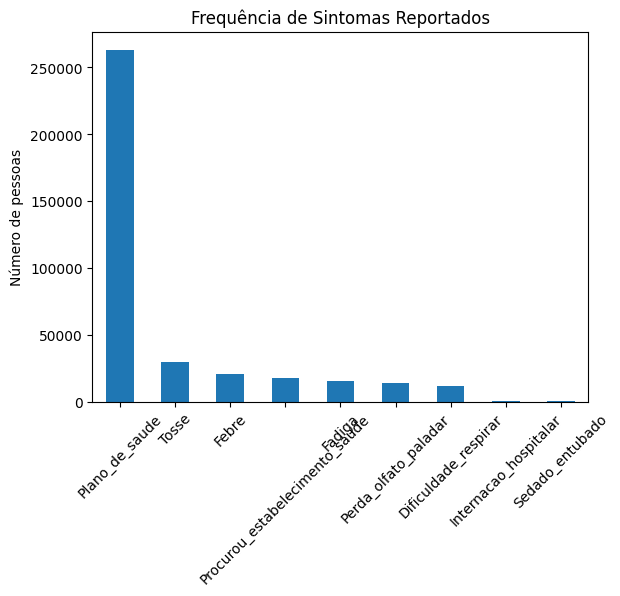

📊 Correlação entre sintomas:


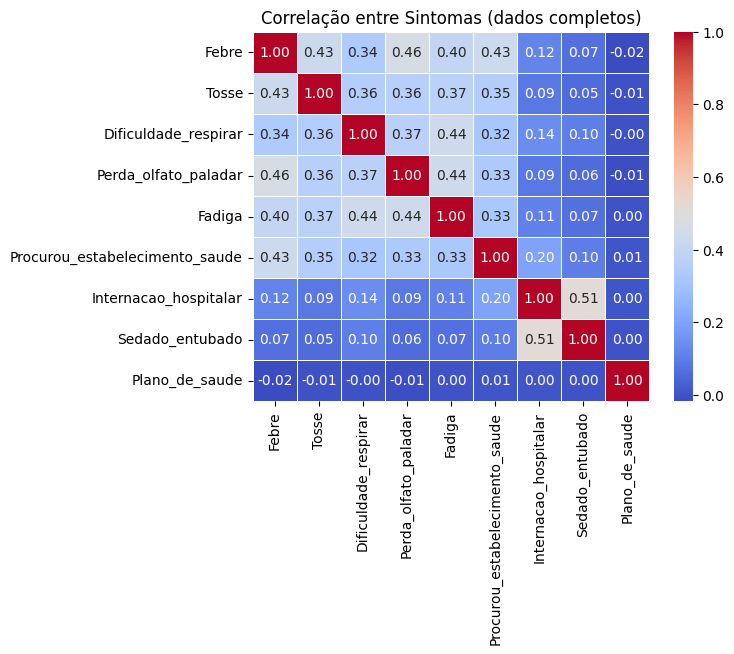

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔄 Substituir "Sim"/"Não" por 1/0
df_sintomas_bin = df_sintomas_final.drop(columns=["UF", "Numero_selecao_domicilio", "mes"])
df_sintomas_bin = df_sintomas_bin.replace({"Sim": 1, "Não": 0})

# 🛠️ Garantir que todas as colunas estão como numéricas
df_sintomas_bin = df_sintomas_bin.apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# 📊 Frequência de sintomas
print("📊 Frequência de Sintomas:")
df_sintomas_bin.sum().sort_values(ascending=False).plot(kind="bar")
plt.title("Frequência de Sintomas Reportados")
plt.ylabel("Número de pessoas")
plt.xticks(rotation=45)
plt.show()

# 🔍 Correlação entre sintomas
print("📊 Correlação entre sintomas:")
corr_matrix = df_sintomas_bin.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlação entre Sintomas (dados completos)")
plt.show()


📊 Correlação entre variáveis de comportamento (corrigido):


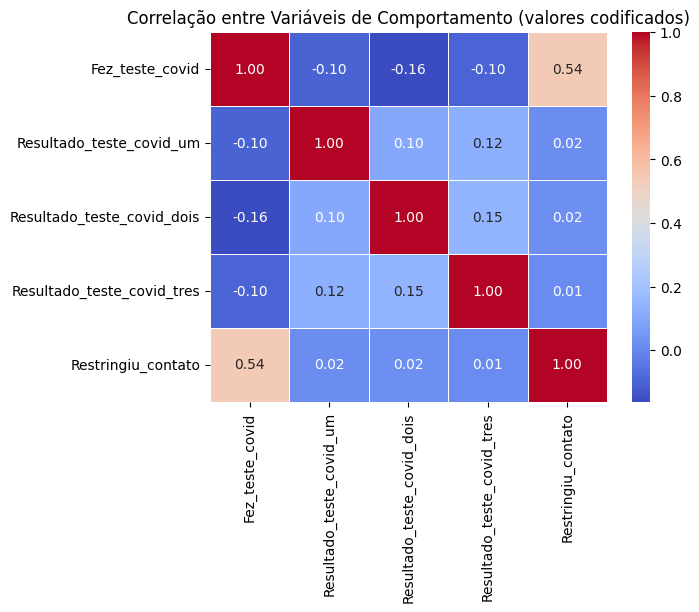

In [12]:
print("📊 Correlação entre variáveis de comportamento (corrigido):")

# Copiar colunas e substituir respostas por números (via cat.codes)
df_comportamento_bin = df_comportamento_final.drop(columns=["UF", "Numero_selecao_domicilio", "mes"]).copy()

# Converter todas as colunas para códigos numéricos (ex: Positivo → 1, Negativo → 0)
df_comportamento_bin = df_comportamento_bin.apply(lambda col: col.astype("category").cat.codes)

# Heatmap com correlação
sns.heatmap(df_comportamento_bin.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlação entre Variáveis de Comportamento (valores codificados)")
plt.show()




📊 Correlação entre variáveis econômicas:


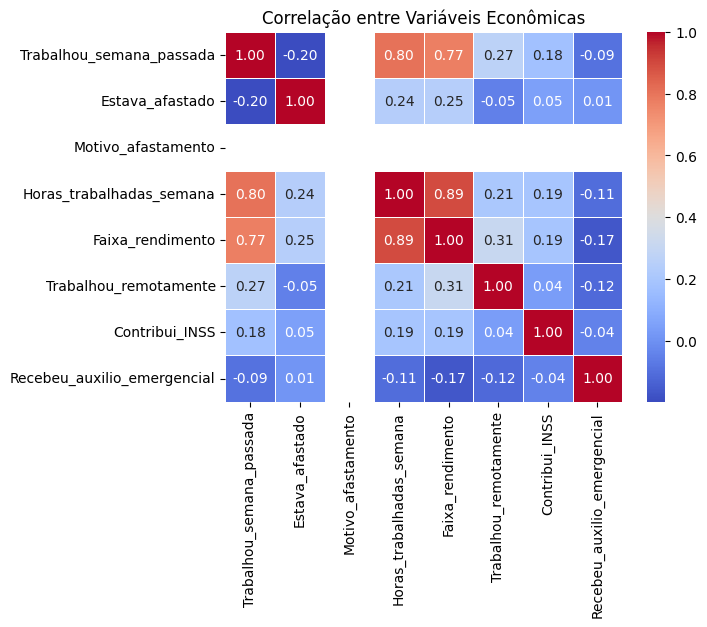

In [13]:
print("📊 Correlação entre variáveis econômicas:")

# Selecionar e converter para 0/1 + manter rendimento e horas trabalhadas
df_economia_bin = df_economia_final.drop(columns=["UF", "Numero_selecao_domicilio", "mes"])
df_economia_bin = df_economia_bin.replace({"Sim": 1, "Não": 0})
df_economia_bin = df_economia_bin.apply(pd.to_numeric, errors="coerce").fillna(0)

# Heatmap de correlação
sns.heatmap(df_economia_bin.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlação entre Variáveis Econômicas")
plt.show()
